In [37]:
import pandas as pd
import numpy as np
import sklearn as sk
import time
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datetime import datetime
from time import strptime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor

#%run './base.ipynb'

# Import Data
Data contains no missing values. Features 'month', 'day' are dtype object.

In [38]:
## import data 
data = pd.read_csv('/Users/annanau/Documents/Workspace/ML_Ex2/data/forest_fires/forestfires.csv')
#display(data.isna().sum()) 
#data.info()
print(data.head(10))

   X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.0
5  8  6   aug  sun  92.3   85.3  488.0  14.7  22.2  29   5.4   0.0   0.0
6  8  6   aug  mon  92.3   88.9  495.6   8.5  24.1  27   3.1   0.0   0.0
7  8  6   aug  mon  91.5  145.4  608.2  10.7   8.0  86   2.2   0.0   0.0
8  8  6   sep  tue  91.0  129.5  692.6   7.0  13.1  63   5.4   0.0   0.0
9  7  5   sep  sat  92.5   88.0  698.6   7.1  22.8  40   4.0   0.0   0.0


# Visualizing/Exploring/Preprocessing
- data contains no missing values
- 'month', 'day' are dtype object, need to be made numeric
- log transformation was applied to response variable 'area' since highly right skewed (R^2 was increased by ~%4)

In [39]:
## Convert 'month', 'day' to numeric variables 
data2 = data
data2['month'] = pd.to_datetime(data['month'], format = '%b').dt.month
data2['day'] = data['day'].apply(lambda x: time.strptime(x, '%a')).apply(lambda x: x.tm_wday)

#data2.info()
#data2.describe()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log(1+area)
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,7.475822,3.259188,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,1.111026
std,2.313778,1.229900,2.275990,2.072929,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,1.398436
min,1.000000,2.000000,1.000000,0.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,7.000000,1.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,8.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.418710
75%,7.000000,5.000000,9.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,2.024193
max,9.000000,9.000000,12.000000,6.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,6.995620


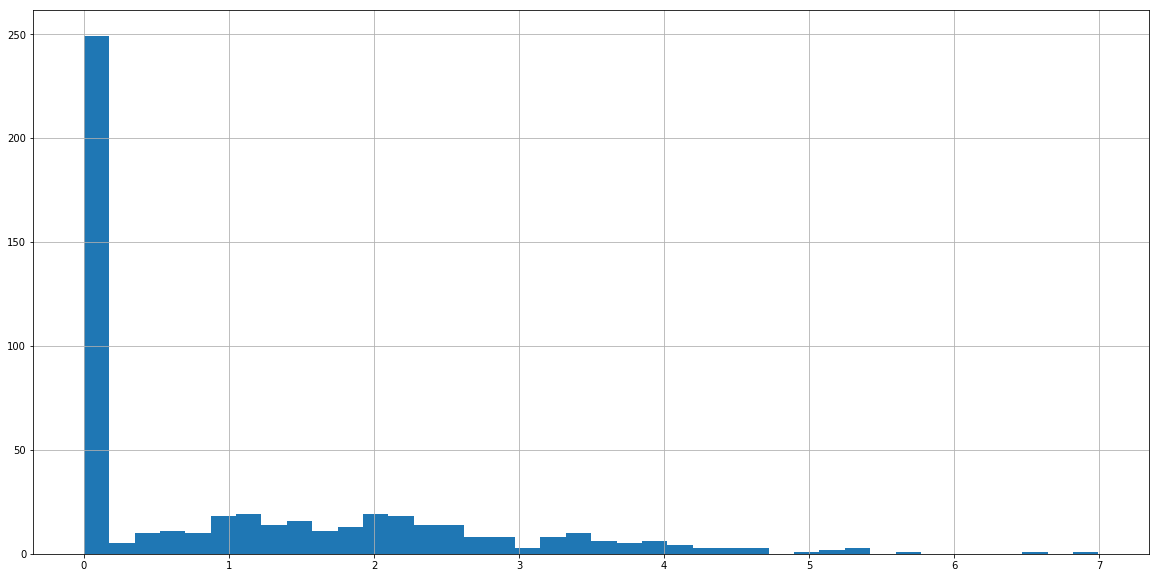

In [40]:
## Explore repsonse variable 'area'
#data2['area'].hist(bins = 40, figsize=(20,10))
#1 - (data2[data2['area'] == 0.0].shape[0]/data2.shape[0]) # for about 52% there is an obs. of a forest fire, 48% 'area' = 0.0

# Distribution of repsonse variable is highly right-skewed so we could apply log transformation
data2['area'] = data2['area'].apply(lambda x: np.log(x+1)) # np.log performs natural log
data2['area'].hist(bins = 40, figsize=(20,10))
data2.rename(index = str, columns = {"area": "log(1+area)"}, inplace = True)
data2.describe()

In [ ]:
## Checking for outliers 
# Descriptive statistics table
display(data.describe())

# Histograms
#data.hist(bins = 30, figsize=(30,20))

In [ ]:
## Scatter Plot Matrix
fig = plt.figure(figsize=(30,30))
ax = fig.subplots()
sm = pd.plotting.scatter_matrix(data2, ax = ax)

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,log(1+area)
X,1.000000,0.539548,-0.065003,-0.024922,-0.021039,-0.048384,-0.085916,0.006210,-0.051258,0.085223,0.018798,0.065387,0.061995
Y,0.539548,1.000000,-0.066292,-0.005453,-0.046308,0.007782,-0.101178,-0.024488,-0.024103,0.062221,-0.020341,0.033234,0.038838
month,-0.065003,-0.066292,1.000000,-0.050837,0.291477,0.466645,0.868698,0.186597,0.368842,-0.095280,-0.086368,0.013438,0.114280
day,-0.024922,-0.005453,-0.050837,1.000000,-0.041068,0.062870,0.000105,0.032909,0.052190,0.092151,0.032478,-0.048340,0.000208
FFMC,-0.021039,-0.046308,0.291477,-0.041068,1.000000,0.382619,0.330512,0.531805,0.431532,-0.300995,-0.028485,0.056702,0.046799
DMC,-0.048384,0.007782,0.466645,0.062870,0.382619,1.000000,0.682192,0.305128,0.469594,0.073795,-0.105342,0.074790,0.067153
DC,-0.085916,-0.101178,0.868698,0.000105,0.330512,0.682192,1.000000,0.229154,0.496208,-0.039192,-0.203466,0.035861,0.066360
ISI,0.006210,-0.024488,0.186597,0.032909,0.531805,0.305128,0.229154,1.000000,0.394287,-0.132517,0.106826,0.067668,-0.010347
temp,-0.051258,-0.024103,0.368842,0.052190,0.431532,0.469594,0.496208,0.394287,1.000000,-0.527390,-0.227116,0.069491,0.053487
RH,0.085223,0.062221,-0.095280,0.092151,-0.300995,0.073795,-0.039192,-0.132517,-0.527390,1.000000,0.069410,0.099751,-0.053662


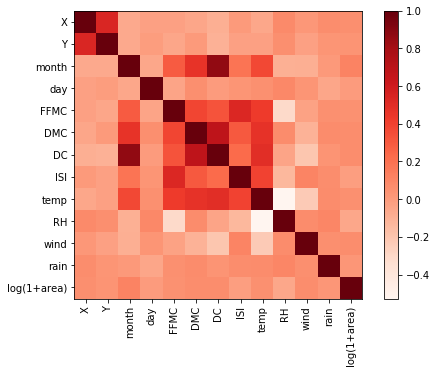

In [69]:
## Correlation 
display(data2.corr())

fig = plt.figure()
ax = fig.add_axes([1,1,1,1])
plt.imshow(data2.corr(), cmap = plt.cm.Reds, interpolation = 'nearest')
plt.colorbar()
ticks = [i for i in range(len(data2.columns))]
plt.xticks(ticks, data2.columns, rotation = 'vertical')
plt.yticks(ticks, data2.columns)
plt.show()

# Prediction Model

In [53]:
## Split into train (size = 2/3) and test data using sklearn's train/test splitter function
X_train, X_test, y_train, y_test = train_test_split(data2.iloc[:, 0:12], data2.iloc[:, 12], test_size = 0.33, random_state= 123)

# Scaler
scaler = preprocessing.StandardScaler().fit(X_train) # standardize data

#print(X_train.shape)
#print(y_train.shape)
#print(X_test.shape)
#print(y_test.shape)

In [67]:
### Regression Models

# Linear Regression
def linear_reg(X_train, y_train, X_test, y_test):
    # Fit model
    reg = LinearRegression().fit(X_train, y_train)
    print(f'R^2 value for model: {reg.score(X_train, y_train)}')
    print(f'Coeffiecients: {reg.coef_}')
    
    # Predict test, compute metrics
    pred = reg.predict(X_test)
    r2_score = reg.score(X_test, y_test)
    mse = mean_squared_error(y_test, pred)
    print(f'MSE: {mse}')
    print(f'R^2 Score: {r2_score}')
    
    return reg

# Gradient Boosted Trees
def run_boosted_tree(X_train, y_train, X_test, y_test, param_fix, cv, param_grid):
    print("GridSearch initializing...")
    clf = GridSearchCV(estimator = GradientBoostingRegressor(**param_fix), cv = cv, param_grid = param_grid, 
                       scoring = ['r2', 'neg_mean_absolute_error', 'neg_mean_squared_error'], 
                       refit = 'neg_mean_squared_error')
    
    print("GradientBoostedRegressor model in training...")
    t0 = time.time()
    clf.fit(X_train, y_train)
    clf_fit = time.time() - t0
    print("GradientBoostedRegressor model selected and fitted in %.3f s\n" % clf_fit)
    
    best_params = clf.best_params_
    print("Best parameters selected by GridSearch: %s" % best_params)
    
    pred = clf.predict(X_test)
    r2_score = clf.score(X_test, y_test)
    mse = mean_squared_error(y_test, pred)
    print(f'MSE: {mse}')
    print(f'R^2 Score: {r2_score}') 
    
    return clf

In [68]:
### Linear Regression 
display('### Linear Regression ###')
reg1 = linear_reg(X_train, y_train, X_test, y_test)

display('### Linear Regression w/ Scaled Data ###')
# Fit model
reg2 = linear_reg(scaler.transform(X_train),y_train, scaler.transform(X_test), y_test)

# Low R^2 value of linear models implies that they are not much better than the baseline model (model consisting of
# intercept only where intercept is the mean of response variable). Similar results for scaled and unscaled data

'### Linear Regression ###'

R^2 value for model: 0.07451358850565404
Coeffiecients: [ 0.08857591  0.05597179  0.06554509 -0.04165653 -0.00020871  0.0006177
 -0.00015392 -0.02170754  0.02822952 -0.00803256  0.10753989  0.02752606]
MSE: 2.050932949339859
R^2 Score: -0.15565990363413595


'### Linear Regression w/ Scaled Data ###'

R^2 value for model: 0.07451358850565404
Coeffiecients: [ 0.20129656  0.06572508  0.14951786 -0.08452525 -0.00093452  0.03920371
 -0.03851154 -0.10007992  0.16253249 -0.13008135  0.19165877  0.00993241]
MSE: 2.050932949339858
R^2 Score: -0.1556599036341353


In [55]:
### Gradient Boosted Trees
param_fix =  {'loss': 'ls', 'learning_rate': 0.01}
cv = 10
param_grid = {'n_estimators': (50, 100, 150, 200, 300, 400, 500), 
              'max_depth': (1, 2, 3, 4, 5), 
              'min_samples_split': (2,3,5)}


display('### Gradient Boosted Trees ###')
# Fit model
gbr = run_boosted_tree(X_train, y_train, X_test, y_test, param_fix, cv, param_grid)

display('### Gradient Boosted Trees w/ Scaled Data ###')
# Fit model
gbr_s = run_boosted_tree(scaler.transform(X_train), y_train, scaler.transform(X_test), y_test,param_fix, cv, param_grid)

# Best parameters were the same for both models, however, fitting runtime and MSE was slightly lower of model fit 
# on standardized data. 
# Low R^2 implies that model is not performing well and that we are better of predicting any sample as 
# equal to the mean of response variable

'### Gradient Boosted Trees ###'

GridSearch initializing...
GradientBoostedRegressor model in training...
GradientBoostedRegressor model selected and fitted in 65.856 s

Best parameters selected by GridSearch: {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 150}
MSE: 1.836682200507843
R^2 Score: -1.836682200507843


'### Gradient Boosted Trees w/ Scaled Data ###'

GridSearch initializing...
GradientBoostedRegressor model in training...
GradientBoostedRegressor model selected and fitted in 62.838 s

Best parameters selected by GridSearch: {'max_depth': 1, 'min_samples_split': 2, 'n_estimators': 150}
MSE: 1.8189002318706557
R^2 Score: -1.8189002318706557
